In [ ]:
# Report the final training loss, training and testing accuracy and plot the final decision boundary

In [11]:
import time
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

In [3]:
# Randomly generate data
N = 5000
x = np.random.uniform(low=0.0, high=1.0, size=(N, 2))
r = np.linalg.norm(x, axis=-1)
y = (r < 1).astype(np.float32)

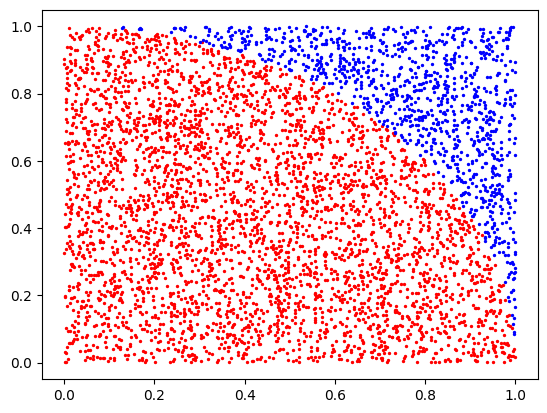

In [4]:
# visualize the data
def plot(x, y):
  plt.figure()
  plt.scatter(x[y==1.0][:, 0], x[y==1.0][:, 1], s=2.0, c='r')
  plt.scatter(x[y==0.0][:, 0], x[y==0.0][:, 1], s=2.0, c='b')
plot(x, y)

In [5]:
# define neural network strcture
#class fc_net(torch.nn.Module):
 # def __init__(self, n_hidden=[100]):
    # (TODO!!!) define your initialization function here
    # you can experiment different number of layers and different number of neurons in each layer
    #  n_hidden: number of neurons in each hidden layer
  #  super(fc_net, self).__init__()


 # def forward(self, x):
    # (TODO!!!) define your forward function here
    #   x: input data
    #   return: prediction of likelihood

class fc_net(torch.nn.Module):
    def __init__(self, n_hidden=[100]):
        super(fc_net, self).__init__()

        # Store the layer configurations
        self.n_hidden = n_hidden
        self.layers = torch.nn.ModuleList()  # Use ModuleList to hold layers

                # Initialize first hidden layer directly
        self.layers.append(torch.nn.Linear(2, self.n_hidden[0]))  # First layer, input size should be 2
        self.layers.append(torch.nn.ReLU())

        # Create subsequent hidden layers if necessary
        for i in range(1, len(n_hidden)):
            self.layers.append(torch.nn.Linear(n_hidden[i - 1], n_hidden[i]))
            self.layers.append(torch.nn.ReLU())

        # Create the output layer
        self.output_layer = torch.nn.Linear(n_hidden[-1], 1)  # Output layer
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid for binary classification

    def forward(self, x):
        # Pass through all layers
        for layer in self.layers:
            x = layer(x)

        # Output layer
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

In [6]:
USE_GPU = False

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [7]:
# split data into training and testing set
x = torch.tensor(x, dtype=torch.float).to(device)
y = torch.tensor(y, dtype=torch.float).to(device)
x_train = x[:4500]
y_train = y[:4500]
x_test = x[4500:]
y_test = y[4500:]

### 3 layer model

In [8]:
# define models and training parameters
N_iter = 100001
lr = 1e-2

# (TODO!!!) define your model, loss function and optimizer here
batch_size = 500
model = fc_net(n_hidden = [32]).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #momentum=0.9) #chatgpt says momentum shouldn't be here

In [13]:
# Training loop
start_time = time.time()

for i in range(N_iter):
    
    # Create a random batch, ensuring batch size does not exceed available samples
    num_samples = y_train.size(0)
    batch_size = min(batch_size, num_samples)  # Adjust batch size if necessary
    batch = torch.randint(0, num_samples, (batch_size,), device=device)

    x_batch = x_train[batch].to(device)
    y_batch = y_train[batch].to(device).unsqueeze(1)  # Reshape y_batch

    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass: compute predicted outputs by passing inputs to the model
    outputs = model(x_batch)

    # Calculate loss
    loss = criterion(outputs, y_batch)
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if i % 250 == 0:
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            p_train = model(x_train.to(device))
            train_loss = criterion(p_train, y_train.to(device).unsqueeze(1))  # Reshape here too

            # Calculate training accuracy
            train_acc = (p_train > 0.5).float().eq(y_train.to(device).unsqueeze(1)).sum() / y_train.size(0)

            # Predictions for the testing set
            p_test = model(x_test.to(device))
            test_acc = (p_test > 0.5).float().eq(y_test.to(device).unsqueeze(1)).sum() / y_test.size(0)

        # Print statistics
        print('Iter {}, time {:.2f}, loss {:.4f}, train_acc {:.3f}, test_acc {:.3f}'.format(
            i, time.time() - start_time, train_loss.item(), train_acc.item(), test_acc.item()
        ))


Iter 0, time 0.17, loss 0.7167, train_acc 0.206, test_acc 0.202
Iter 250, time 0.92, loss 0.1023, train_acc 0.963, test_acc 0.958
Iter 500, time 1.78, loss 0.0916, train_acc 0.961, test_acc 0.958
Iter 750, time 2.59, loss 0.0941, train_acc 0.964, test_acc 0.962
Iter 1000, time 3.03, loss 0.0903, train_acc 0.960, test_acc 0.958
Iter 1250, time 3.47, loss 0.0936, train_acc 0.958, test_acc 0.954
Iter 1500, time 3.92, loss 0.0918, train_acc 0.959, test_acc 0.954
Iter 1750, time 4.50, loss 0.0921, train_acc 0.959, test_acc 0.954
Iter 2000, time 5.07, loss 0.0903, train_acc 0.959, test_acc 0.952
Iter 2250, time 6.10, loss 0.0904, train_acc 0.960, test_acc 0.952
Iter 2500, time 6.57, loss 0.0903, train_acc 0.960, test_acc 0.952
Iter 2750, time 7.03, loss 0.0915, train_acc 0.963, test_acc 0.958
Iter 3000, time 7.48, loss 0.0912, train_acc 0.959, test_acc 0.956
Iter 3250, time 8.30, loss 0.0911, train_acc 0.962, test_acc 0.960
Iter 3500, time 10.55, loss 0.0904, train_acc 0.960, test_acc 0.962


In [29]:
import numpy as np
import matplotlib as plt
# plot training boundry
x_plot = np.random.uniform(low=0.0, high=1.0, size=(10000, 2))
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float).to(device)
with torch.no_grad():
  x_pred = (model(x_plot_tensor).squeeze() > 0.5).float().cpu().numpy()
plt.plot(x_plot, x_pred)
plt.savefig("3_layer_pytorch.png")
plt.show()

RuntimeError: Numpy is not available

In [31]:
import sys
print(sys.executable)

!pip3 install --upgrade numpy

/usr/local/bin/python3
  Using cached numpy-2.1.2-cp312-cp312-macosx_10_13_x86_64.whl.metadata (60 kB)
Using cached numpy-2.1.2-cp312-cp312-macosx_10_13_x86_64.whl (20.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Rolling back uninstall of numpy
  Moving to /Library/Frameworks/Python.framework/Versions/3.12/bin/f2py
   from /private/var/folders/3b/rj1jcqm919zg058n2dh4xbk00000gp/T/pip-uninstall-wa5oyzb_/f2py
  Moving to /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy-1.26.4.dist-info/
   from /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/~umpy-1.26.4.dist-info
  Moving to /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/
   from /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/~umpy
ERROR: Could not install packages due to an OSError: [Er

### 4 layer model

In [21]:
# define models and training parameters
N_iter = 100001
lr = 1e-2

# (TODO!!!) define your model, loss function and optimizer here
batch_size = 500
model = fc_net([8,8]).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #momentum=0.9)

In [23]:
# Training loop
start_time = time.time()

for i in range(N_iter):
    
    # Create a random batch, ensuring batch size does not exceed available samples
    num_samples = y_train.size(0)
    batch_size = min(batch_size, num_samples)  # Adjust batch size if necessary
    batch = torch.randint(0, num_samples, (batch_size,), device=device)

    x_batch = x_train[batch].to(device)
    y_batch = y_train[batch].to(device).unsqueeze(1)  # Reshape y_batch

    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass: compute predicted outputs by passing inputs to the model
    outputs = model(x_batch)

    # Calculate loss
    loss = criterion(outputs, y_batch)
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if i % 250 == 0:
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            p_train = model(x_train.to(device))
            train_loss = criterion(p_train, y_train.to(device).unsqueeze(1))  # Reshape here too

            # Calculate training accuracy
            train_acc = (p_train > 0.5).float().eq(y_train.to(device).unsqueeze(1)).sum() / y_train.size(0)

            # Predictions for the testing set
            p_test = model(x_test.to(device))
            test_acc = (p_test > 0.5).float().eq(y_test.to(device).unsqueeze(1)).sum() / y_test.size(0)

        # Print statistics
        print('Iter {}, time {:.2f}, loss {:.4f}, train_acc {:.3f}, test_acc {:.3f}'.format(
            i, time.time() - start_time, train_loss.item(), train_acc.item(), test_acc.item()
        ))



Iter 0, time 0.08, loss 0.0142, train_acc 0.995, test_acc 0.990
Iter 250, time 0.88, loss 0.0135, train_acc 0.996, test_acc 0.992
Iter 500, time 1.46, loss 0.0132, train_acc 0.996, test_acc 0.990
Iter 750, time 2.37, loss 0.0216, train_acc 0.991, test_acc 0.984
Iter 1000, time 3.13, loss 0.0129, train_acc 0.996, test_acc 0.990
Iter 1250, time 3.91, loss 0.0128, train_acc 0.996, test_acc 0.988
Iter 1500, time 4.96, loss 0.0134, train_acc 0.994, test_acc 0.996
Iter 1750, time 6.09, loss 0.0128, train_acc 0.995, test_acc 0.992
Iter 2000, time 7.90, loss 0.0136, train_acc 0.995, test_acc 0.986
Iter 2250, time 8.78, loss 0.0130, train_acc 0.996, test_acc 0.994
Iter 2500, time 9.33, loss 0.0123, train_acc 0.995, test_acc 0.990
Iter 2750, time 9.92, loss 0.0123, train_acc 0.996, test_acc 0.990
Iter 3000, time 10.63, loss 0.0185, train_acc 0.992, test_acc 0.984
Iter 3250, time 11.76, loss 0.0116, train_acc 0.996, test_acc 0.990
Iter 3500, time 12.50, loss 0.0145, train_acc 0.994, test_acc 0.98

In [24]:
# plot training boundry
x_plot = np.random.uniform(low=0.0, high=1.0, size=(10000, 2))
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float).to(device)
with torch.no_grad():
  x_pred = (model(x_plot_tensor).squeeze() > 0.5).float().cpu().numpy()
plot(x_plot, x_pred)
plt.savefig("4_layer_pytorch.png")

RuntimeError: Numpy is not available